# Integration tests for the GoFigr Python client

In [1]:
import json
from platform import platform
from collections import defaultdict

from gofigr.jupyter import *
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

from datetime import datetime

from uuid import uuid4
from gofigr.jupyter import _GF_EXTENSION as extension
from gofigr.backends.matplotlib import MatplotlibBackend
from gofigr.backends.plotly import PlotlyBackend
from gofigr.widget import *

try:
    import py3Dmol
except:
    print("Warning: running without py3dmol", file=sys.stderr)

START_TIME = datetime.now()
TEST_RESULTS = []

def sync():
    with open("integration_test.json", "w") as f:
        json.dump({
            'platform': platform(),
            'elapsed_seconds': (datetime.now() - START_TIME).total_seconds(),
            'results': TEST_RESULTS
            }, f, indent=4)

def check_text(txt, min_len=10):
    return txt is not None and txt.strip() not in ["N/A", "NA"] and len(txt.strip()) >= min_len

def check_figure(test_name, workspace, analysis_name, fig_name, expected_revisions=1):
    res = defaultdict(lambda: True)
    res["test_name"] = test_name
    res["error"] = None
    
    try:    
        ana = workspace.get_analysis(analysis_name, create=False)
        fig = ana.get_figure(fig_name, create=False)

        res["elapsed_seconds"] = (datetime.now() - START_TIME).total_seconds()
        res["number_of_revisions"] = len(fig.revisions) == expected_revisions

        for rev in fig.revisions:
            rev.fetch()
            res["notebook_name"] = res["notebook_name"] and \
                check_text(rev.metadata["notebook_name"])
            res["notebook_path"] = res["notebook_path"] and \
                check_text(rev.metadata["notebook_path"]) and os.path.exists(rev.metadata["notebook_path"])
            res["backend"] = res["backend"] and check_text(rev.metadata["backend"], min_len=5)
            res["kernel"] = res["kernel"] and check_text(rev.metadata["kernel"], min_len=5)
            res["python_version"] = res["python_version"] and check_text(rev.metadata["python_version"], min_len=4)
            
            for img in rev.image_data:
                image_key = f"image_{img.format}" + ("_watermark" if img.is_watermarked else "")
                res[image_key] = res[image_key] and len(img.data) > 1000

            for code in rev.code_data:
                txt = code.contents.strip()
                if 'history' not in code.metadata['format']:
                    res["cell_code"] = res["cell_code"] and check_text(txt)
                else:
                    res["history"] = res["history"] and check_text(txt, 50)
                
            for td in rev.text_data:
                txt = td.contents.strip()
                res['text'] = res["text"] and check_text(txt)
                
    except Exception as e:
        res["error"] = str(e)
            
    return dict(res.items())

# MPL: load the extension and publish a figure from the same cell

The gofigr extension is already loaded. To reload it, use:
  %reload_ext gofigr


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'ac691a77-a134-4304-b83f-4a1c91d9520e')

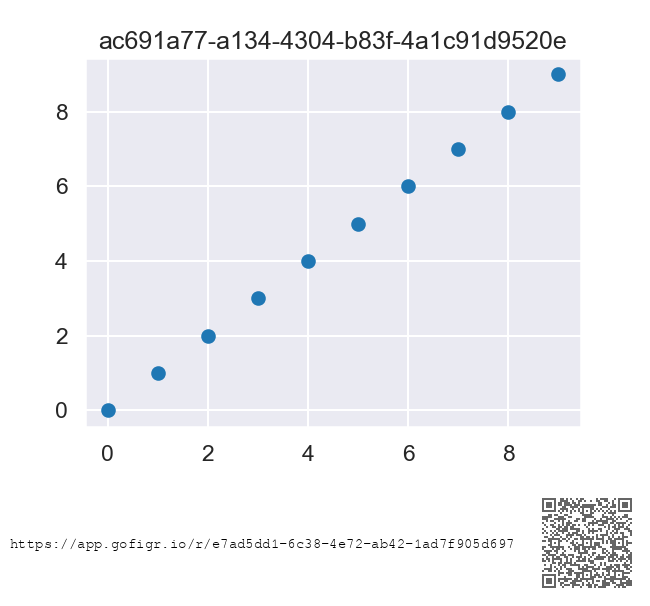


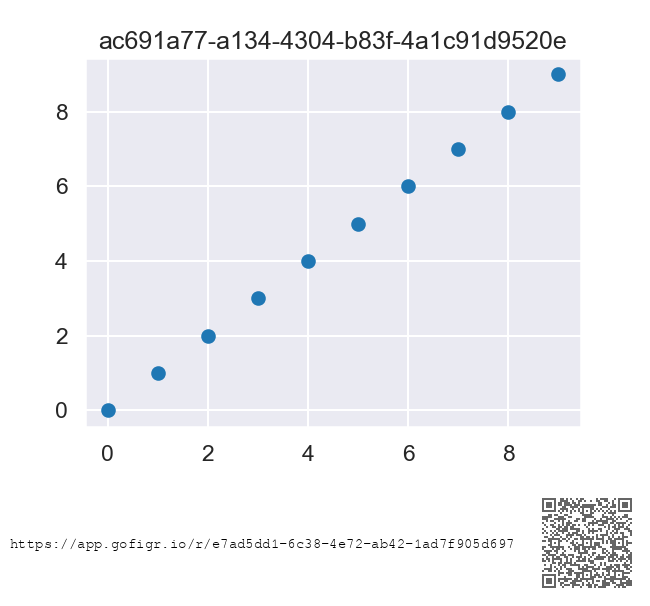
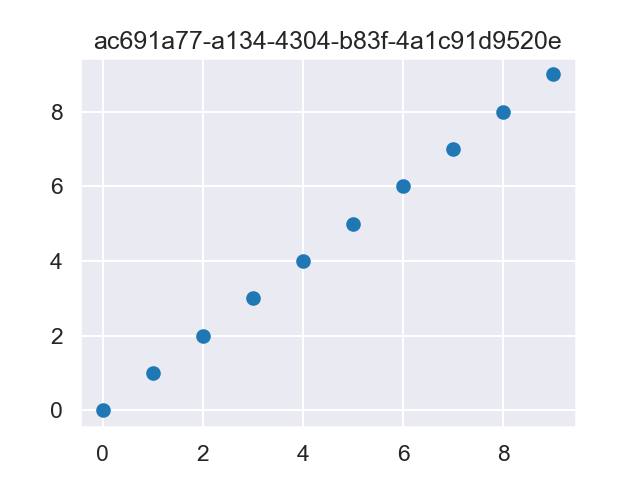
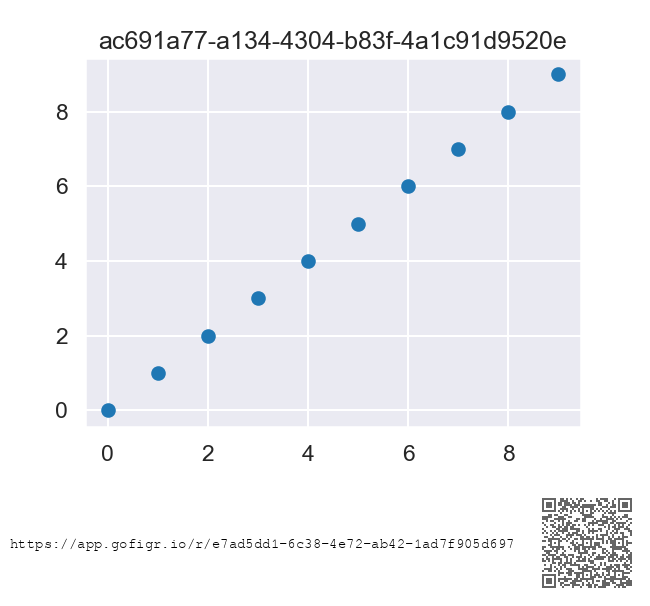
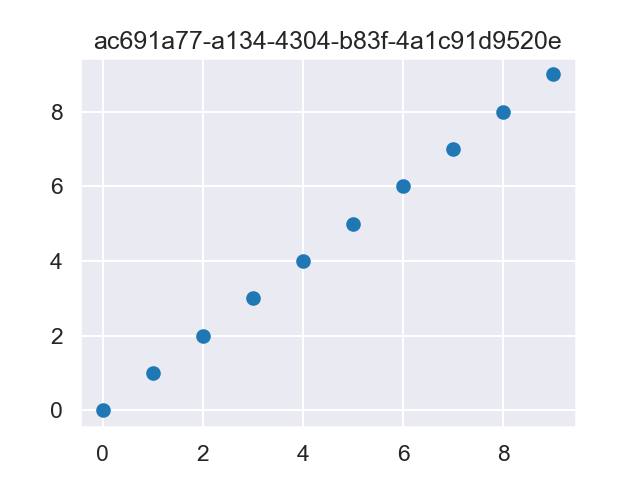

In [3]:
%load_ext gofigr

sns.set_style("darkgrid")
sns.set_context("talk") 

configure(workspace=None,
          auto_publish=True,
          analysis=FindByName("Integration tests", create=True),
          username=os.environ['GF_TEST_USER'],
          password=os.environ['GF_TEST_PASSWORD'],
          api_key=None,
          url="https://api-dev.gofigr.io",
          widget_class=DetailedWidget)

gf = get_gofigr()

# Try plotting in the same cell as configure(). auto_publish will break, but we should at least
# get a warning
fig_title1 = str(uuid4())
plt.figure()
plt.scatter(range(10), range(10))
plt.title(fig_title1)

In [ ]:
TEST_RESULTS.append(check_figure("MPL: Configure and publish in one cell", gf.primary_workspace, "Integration tests", fig_title1))
sync()

# MPL: Anonymous figure

In [ ]:
plt.scatter(x=range(10), y=range(10))

In [ ]:
TEST_RESULTS.append(check_figure("MPL: Anonymous figure", gf.primary_workspace, "Integration tests", "Anonymous Figure"))
sync()

# MPL: Manual call to publish

In [ ]:
iris = sns.load_dataset("iris")

title2 = str(uuid4())

plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title2)

publish(target=FindByName(title2, create=True),
        dataframes={"IRIS": iris})

In [ ]:
TEST_RESULTS.append(check_figure("MPL: Manual publish", gf.primary_workspace, "Integration tests", title2))
sync()

# MPL: Auto publish

In [ ]:
iris = sns.load_dataset("iris")

title3 = str(uuid4())
plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title3)

In [ ]:
TEST_RESULTS.append(check_figure("MPL: Auto publish", gf.primary_workspace, "Integration tests", title3))
sync()

# MPL: Add revision

In [ ]:
# Add a new revision to the same figure
plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title3)

In [ ]:
TEST_RESULTS.append(check_figure("MPL: Auto-publish second revision", gf.primary_workspace, "Integration tests", title3,
                                expected_revisions=2))
sync()

# MPL: Inline backend

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

title4 = str(uuid4())
plt.figure()
plt.scatter(range(10), range(10))
plt.title(title4)

In [ ]:
TEST_RESULTS.append(check_figure("MPL: inline backend", gf.primary_workspace, "Integration tests", title4))
sync()

# MPL: Mix-and-match manual and auto publish

In [ ]:
title5 = str(uuid4())
plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title5)
publish()

plt.figure(figsize=(4, 4))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="Set1")
plt.title(title5)

In [ ]:
TEST_RESULTS.append(check_figure("MPL: Mix manual and auto-publish", gf.primary_workspace, "Integration tests", title5, expected_revisions=2))
sync()

# MPL: Subplots

In [ ]:
import numpy as np

title6 = str(uuid4())
fig, ax = plt.subplots(nrows=2, ncols=2)
ax = np.ravel(ax)

for idx, axis in enumerate(ax):
    axis.scatter(x=np.random.normal(loc=idx, size=100), y=np.random.normal(loc=idx, size=100))

fig.suptitle(title6)

In [ ]:
TEST_RESULTS.append(check_figure("MPL: Subplots", gf.primary_workspace, "Integration tests", title6, expected_revisions=1))
sync()

# Plotly

## Static figure

In [ ]:
import plotly
plotly.io.kaleido.scope.default_width = 800
plotly.io.kaleido.scope.default_height = 600

In [ ]:
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)

title7 = str(uuid4())

N = 100
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
sz = np.random.rand(N) * 30

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode="markers",
    marker=go.scatter.Marker(
        size=sz,
        color=colors,
        opacity=0.6,
        colorscale="Viridis"
    )))
fig.update_layout(title=title7)

fig.show()

publish(fig=fig, image_options={'width': 800, 'height': 600})
publish(fig=fig, image_options={'width': 1000, 'height': 800})

In [ ]:
TEST_RESULTS.append(check_figure("Plotly - manual publish", gf.primary_workspace, "Integration tests", title7, expected_revisions=3))
sync()

## Plotly -- autopublish

In [ ]:
import plotly.express as px

title8 = str(uuid4())
df = px.data.iris()
fig = px.scatter(df, x="sepal_length", y="sepal_width", color="species",
                title=title8)
fig.show()

In [ ]:
TEST_RESULTS.append(check_figure("Plotly - autopublish", gf.primary_workspace, "Integration tests", title8, expected_revisions=1))
sync()

# Py3Dmol

In [ ]:
title10 = str(uuid4())
p = py3Dmol.view(query='mmtf:1ycr')
p.setStyle({'cartoon': {'color':'spectrum'}})
p.title = title10
p

In [ ]:
TEST_RESULTS.append(check_figure("Py3Dmol - autopublish", gf.primary_workspace, "Integration tests", title10, expected_revisions=1))
sync()

# Py3DMol -- call to show

In [ ]:
title10b = str(uuid4())
p = py3Dmol.view(query='mmtf:1ycr', width=1920, height=200)
p.setStyle({'cartoon': {'color':'spectrum'}})
p.title = title10b
p.show()

In [ ]:
TEST_RESULTS.append(check_figure("Py3Dmol - call to show()", gf.primary_workspace, "Integration tests", title10b, expected_revisions=1))
sync()

# Py3Dmol -- manual publish

In [ ]:
title11 = str(uuid4())
p = py3Dmol.view(query='mmtf:1ycr')
p.setStyle({'cartoon': {'color':'spectrum'}})
p.title = title11
publish(p)

In [ ]:
TEST_RESULTS.append(check_figure("Py3Dmol - manual publish", gf.primary_workspace, "Integration tests", title11, expected_revisions=1))
sync()

# Py3Dmol -- call to show and return view from cell

In [ ]:
title12 = str(uuid4())
p = py3Dmol.view(query='mmtf:1ycr')
p.setStyle({'cartoon': {'color':'spectrum'}})
p.title = title12
p.show()
p

In [ ]:
TEST_RESULTS.append(check_figure("Py3Dmol - call to show and return view from cell", gf.primary_workspace, "Integration tests", title12, expected_revisions=1))
sync()

# Save results

In [ ]:
with open("integration_test.json.done", "w") as f:
    f.write("done\n")

In [ ]:
!pwd

In [ ]:
print(f"Finished in {datetime.now() - START_TIME}")